## Домашняя работа 3. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — кросс-валидация. Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

<font color=blue>Сделаем импорт всех необходимых библиотек/классов/функций.</font>

In [1]:
import math
import time
import warnings
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

<font color=blue>Загрузим датасет в pandas датафрейм.</font>

In [2]:
df = pd.read_csv('data.adult.csv')

<font color=blue>Взглянем на размер фрейма и первые несколько строк.</font>

In [3]:
df.shape

(16280, 14)

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**(0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

<font color=blue>Заменим все пропущенные значения "?" на `np.nan`, а потом удалим все строки с помощью метода `dropna`.</font>

In [5]:
#your code here
data = df.replace('?', np.nan)
data = data.dropna(ignore_index=True)
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

<font color=blue>Взглянем на размер фрейма после обработки и выведем его.</font>

In [6]:
data.shape

(15347, 14)

In [7]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
15343,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
15344,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
15345,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

<font color=blue>Целевую переменную `>50K,<=50K` поместим в датафрейм `y`, а остальную таблицу в датафрейм `X`.</font>

In [8]:
#your code here
X = data.drop(columns=['>50K,<=50K'])
y = data['>50K,<=50K']

In [9]:
X.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40


<font color=blue>Посмотрим какие разные значения встречаются в `y`.</font>

In [10]:
y.value_counts()

>50K,<=50K
<=50K    11407
>50K      3940
Name: count, dtype: int64

<font color=blue>Заменим значение `<=50K` на 0, а значение `>50K` на 1.</font>

In [11]:
y = y.replace('<=50K', 0)
y = y.replace('>50K', 1)

<font color=blue>Проверим теперь какова структура `y`.</font>

In [12]:
y.value_counts()

>50K,<=50K
0    11407
1     3940
Name: count, dtype: int64

<font color=blue> Посмотрим какие признаки есть в `X`. </font>

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15347 entries, 0 to 15346
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 1.5+ MB


<font color=blue>Все признаки типа `object` - категориальные. Остальные вещественные. Создадим соответствующие списки. </font>

In [14]:
categorical_features = X.dtypes[X.dtypes == 'object'].index
numeric_features = X.dtypes[X.dtypes != 'object'].index

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 5-fold cv.

**(1.5 балла)** Для каждого из первых двух алгоритмов подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

<font color=blue>Поместим в датафрейм `X_num` только вещественные данные.</font>

In [15]:
#your code here
X_num = X[numeric_features]
X_num.head(5)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


<font color=blue>Создадим словарь `experiments`, куда будем сохранять результаты экспериментов.</font>

In [16]:
experiments = {'kNN': list(),
               'SGD': list(),
               'Logistic Regression': list(),
               'SVC': list(),
               'GNB': list()}

<font color=blue>Зафиксируем случайность.</font>

In [17]:
seed = 27316
random.seed(seed)
np.random.seed(seed)

<font color=blue> Создадим объект `skf` класса `StratifiedKFold`, который будем использовать для кросс-валидации наших моделей. Особенность этого класса заключается в том, что его метод разделения выборки на трейн и тест происходит с соблюдением баланса классов.</font>

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

<font color=blue>Функция `run_grid_search` осуществляет поиск лучших гиперпараметров модели с помощью кросс валидации, используя метрику `roc_auc`. Возвращает объект класса `GridSearchCV` с результами поиска. </font>

In [19]:
def run_grid_search(estimator, params, X, y, cls_name, verbose=True, grid_verbose=1):
    grid = GridSearchCV(estimator, params, cv=skf, scoring='roc_auc', verbose=grid_verbose)
    grid.fit(X, y)
    
    experiments[cls_name].append(grid.best_params_)
    experiments[cls_name].append(f'{grid.best_score_:0.4f}')
    
    if verbose:
        print(f'Лучшие гиперпараметры для {cls_name}:  {grid.best_params_}')
        
    return grid

<font color=blue>Функция `plot_cv_results` визуализирует результаты поиска: изображаются точки среднего (по 5 фолдам) значения `roc_auc` и доверительный интервал (стандартное отклоение от среднего).</font>

In [20]:
def plot_cv_results(cls_grid, param_key, cls_name, ticks=False, logparam=False):
    cls_mean_test_score = cls_grid.cv_results_['mean_test_score']
    cls_std_test_score =  cls_grid.cv_results_['std_test_score']
    cls_params = [param[param_key] for param in cls_grid.cv_results_['params']]
    
    if logparam:
        cls_params = [math.log10(p) for p in cls_params]
    
    plt.figure(figsize=(10, 5))
    plt.title(f"{cls_name}: средний ROC-AUC по пяти фолдам кросс-валидации и доверительный интервал (отклонение от среднего)")
    plt.errorbar(cls_params, cls_mean_test_score, yerr=cls_std_test_score, fmt='o', markersize=3, ecolor='red', capsize=3)
    for i, txt in enumerate(cls_mean_test_score):
        plt.annotate(np.round(txt, 4), 
                     (cls_params[i], cls_mean_test_score[i]),
                     textcoords="offset points",
                     xytext=(+20,0),
                     ha='center',
                     fontsize=8)
    if ticks:
        plt.xticks(range(len(cls_params)), cls_params, rotation=45)
    plt.xlabel(f'log({param_key})' if logparam else f'{param_key}')
    plt.ylabel('ROC-AUC')
    plt.grid(True)
    plt.show()


<font color=blue>Отключим вывод предупреждений.</font>

In [21]:
warnings.filterwarnings('ignore')

<font color=blue>Создадим списки для поиска лучших гиперпараметров и создадим модели - объекты классов `KNeighborsClassifier` и `SGDClassifier`.</font>

In [22]:
knn_params = {'n_neighbors': range(1, 10)}
sgd_params = {'loss': ['hinge', 'log_loss', 'modified_huber', 
                       'squared_hinge', 'perceptron', 'squared_error', 
                       'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}

knn = KNeighborsClassifier()
sgd = SGDClassifier(max_iter=10000, random_state=seed)

<font color=blue> Осуществим поиск наилучших гиперпараметров и визуализируем результаты. </font>

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Лучшие гиперпараметры для kNN:  {'n_neighbors': 6}


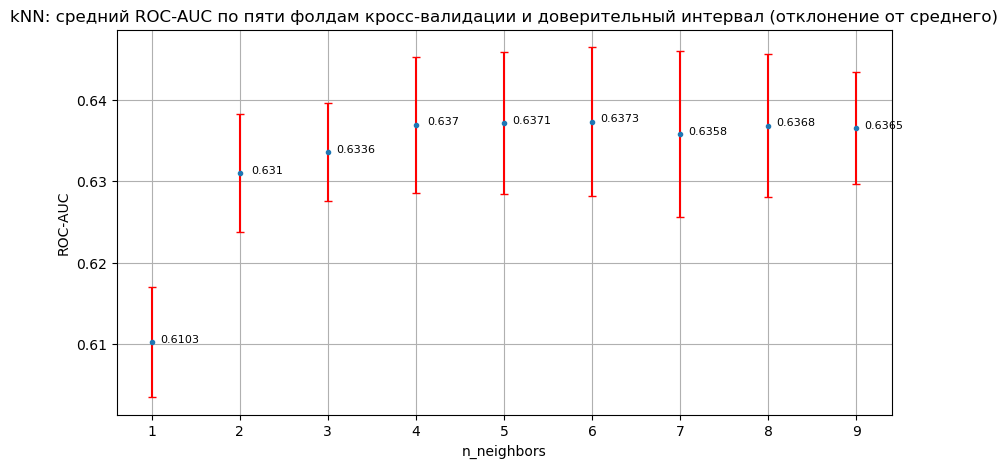

In [23]:
knn_grid = run_grid_search(knn, knn_params, X_num, y, 'kNN')
plot_cv_results(knn_grid, 'n_neighbors', 'kNN')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Лучшие гиперпараметры для SGD:  {'loss': 'squared_hinge'}


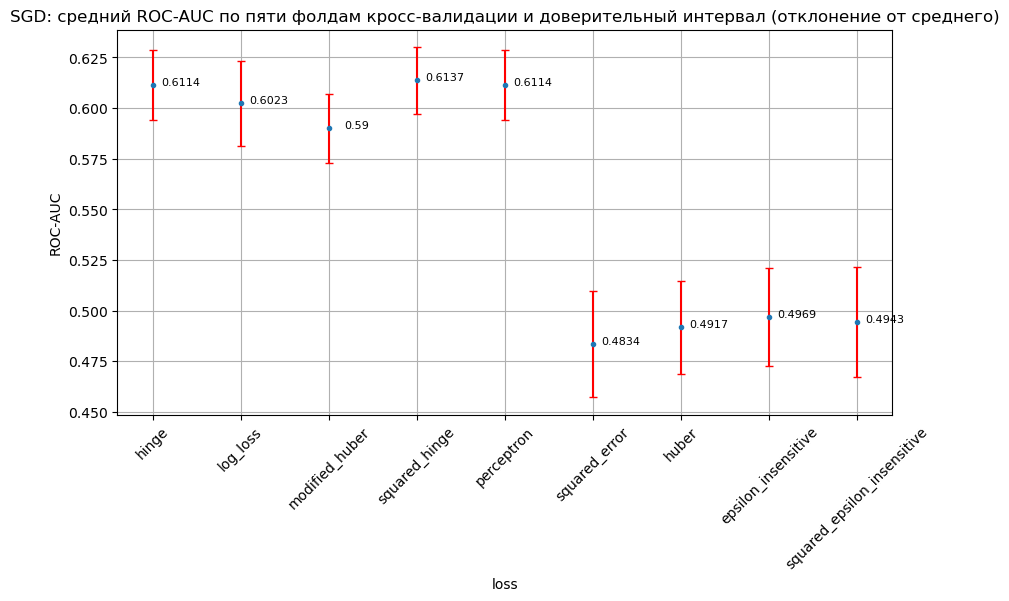

In [24]:
sgd_grid = run_grid_search(sgd, sgd_params, X_num, y, 'SGD')
plot_cv_results(sgd_grid, 'loss', 'SGD', ticks=True)

Что вы можете сказать о получившихся графиках?

**(0.75 балла)** Также подберём параметр регуляризации C в алгоритмах LogisticRegression и SVC.

<font color=blue>Для классификатора `kNN` четкий максимум не выражен, а наилучшее качество дал гиперпараметр `n_neighbors=6`. Для классификатора `SGD` также максимум не выражен, а лучшей функцией потерь в итоге оказалась `squared_hinge`.</font>

<font color=blue>Теперь проделаем такие же вычисления для `LogisticRegression` и `SVC`</font> 

In [25]:
#your code here
logreg_params = {'C': [0.001, 0.1, 0.3, 0.6, 0.9,  1.0]}
svc_params = {'C': [0.001, 0.1, 0.3, 0.6, 0.9,  1.0]}

logreg = LogisticRegression(max_iter=1000, random_state=seed)
svc = SVC(random_state=seed)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие гиперпараметры для Logistic Regression:  {'C': 0.001}


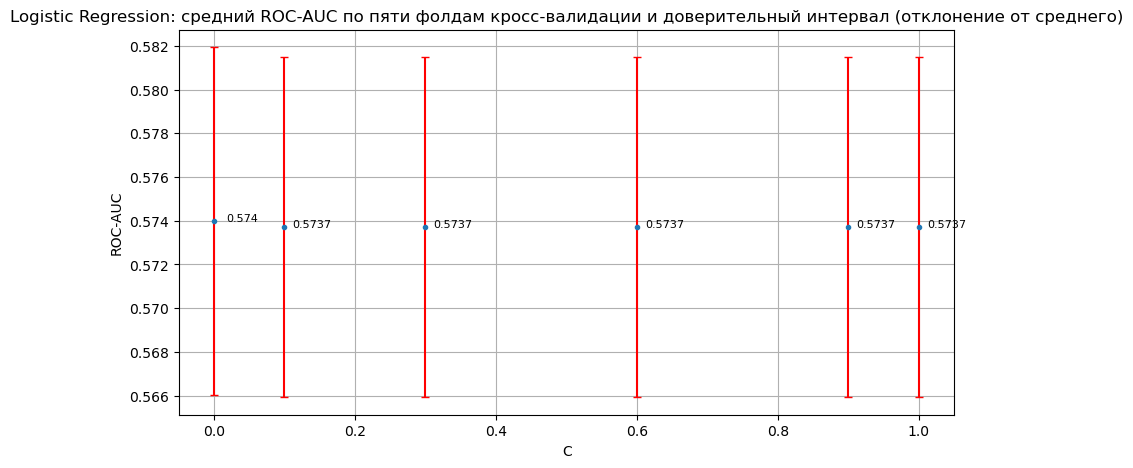

In [26]:
logreg_grid = run_grid_search(logreg, logreg_params, X_num, y, 'Logistic Regression')
plot_cv_results(logreg_grid, 'C', 'Logistic Regression')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие гиперпараметры для SVC:  {'C': 0.3}


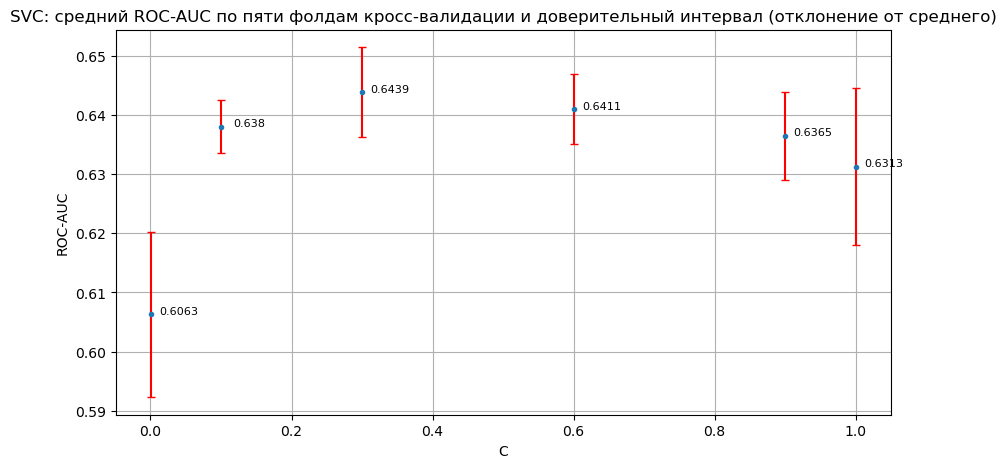

In [27]:
svc_grid = run_grid_search(svc, svc_params, X_num, y, 'SVC')
plot_cv_results(svc_grid, 'C', 'SVC')

**(0.75 балла)** Изучите документацию по алгоритму [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) и подберите возможные гиперпараметры для этого алгоритма.

<font color=blue>Из набора классификаторов библиотеки `sklearn.naive_bayes` выберем `GaussianNB`.</font> 

In [28]:
#your code here
gnb = GaussianNB()
gnb_params  = {'var_smoothing': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}

<font color=blue>Для наглядности результатов по классификатору `GaussianNB` горизонтальная шкала (шкала значений гиперпараметра) прологорифмирована.</font>

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Лучшие гиперпараметры для GNB:  {'var_smoothing': 1e-10}


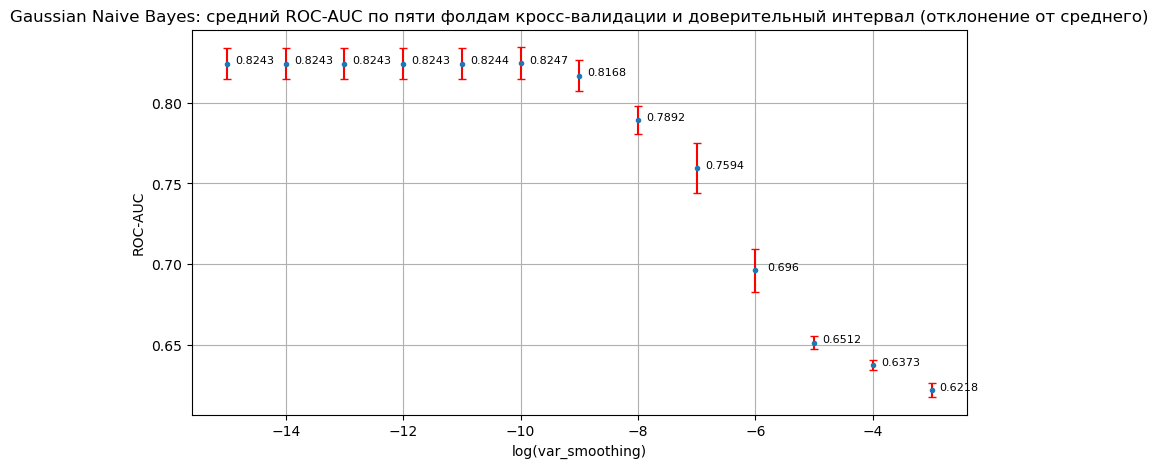

In [29]:
gnb_grid = run_grid_search(gnb, gnb_params, X_num, y, 'GNB')
plot_cv_results(gnb_grid, 'var_smoothing', 'Gaussian Naive Bayes', logparam=True)

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**(0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

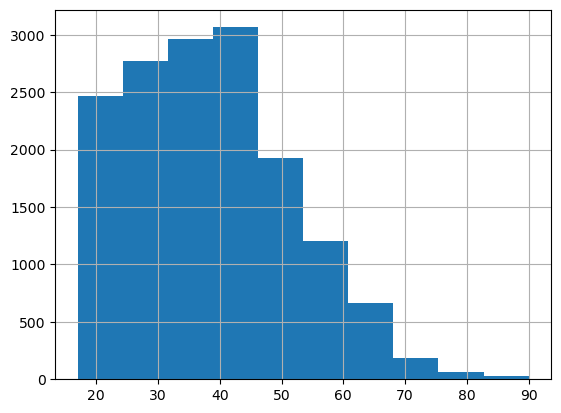

In [30]:
#your code here
_ = X_num.age.hist()

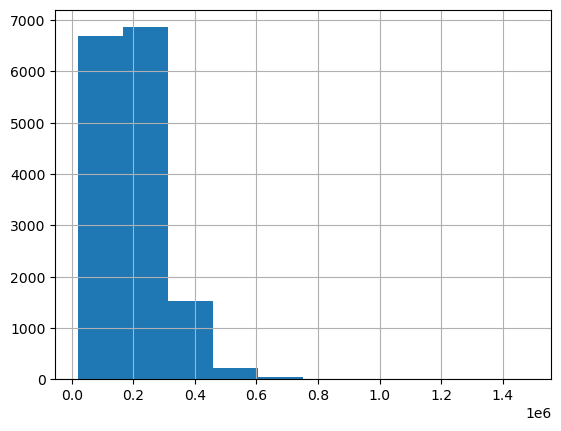

In [31]:
_ = X_num.fnlwgt.hist()

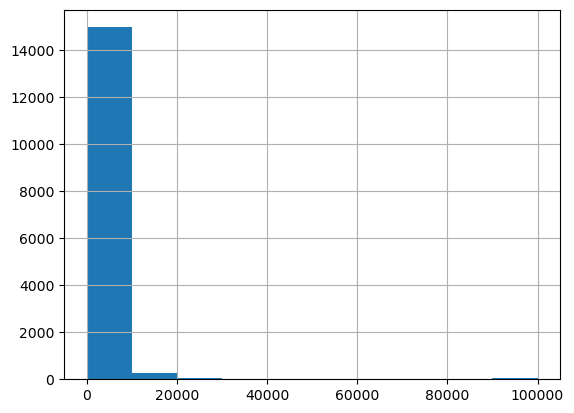

In [32]:
_ = X_num['capital-gain'].hist()

<font color=blue>Судя по гистограммам признаки принимают значения значительно превышающие по модулю единицу (на 3-4 порядка!). Что, во-первых, негативно сказывается на скорость сходимости таких алгоритмов как `SGDClassifier` и `LogisticRegression` - значение по умолчанию максимального числа итераций в этих алгоритмах явно недостаточно (забегая вперед это будет видно по результатам обучения после масштабирования этих признаков). А, во-вторых, негативно сказывается на результат обучения таких алгоритмов как `KNeighborsClassifier` и `SVC`, т.к. в них важную роль играет метрика в пространстве признаков: eсли масштаб одного из признаков существенно больше других, то он будет доминировать в расчетах, что приведет к пониженному качеству модели. Алгоритм же `GaussianNB` уже достиг достаточно высокого качества (при оптимальном гиперпараметре `var_smoothing`) - это указывает на то, что к масштабу признаков он не так чувствителен - возможно потому, что он построен на анализе распределения условных вероятностей, которые не зависят от масштаба.</font>

<font color=blue>Кроме прочего по гистограмме видно, что признак `capital-gain` имеет распределение с тяжелым хвостом, что может негативно сказаться на алгоритм `GaussianNB`, т.к. этот алгоритм исходит из того, что все признаки распределены нормально.</font>

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

<font color=blue>Учитывая, что в датасете есть признаки, распределение которых имеет тяжелый хвост, т.е. большие отклонения значений этих признаков нельзя считать выбросами, то предпочтительней выглядит метод `StandardScaler`. В противном случае величина $x_{max}-x_{min}$ может оказаться много больше типичного значения (например медианы или моды) нормализуемого признака и мы рискуем получить после нормализации вида $\frac{x-x_{min}}{x_{max}-x_{min}}$ величины очень близкие к нулю для большой части объектов датасета.</font>

In [33]:
#your code here
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

In [34]:
pd.DataFrame(X_num_scaled)

,0,1,2,3,4,5
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178
...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178


<font color=blue>Подберем для наших 5 моделей оптимальные гиперпараметры на нормализованных данных.</font>

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Лучшие гиперпараметры для kNN:  {'n_neighbors': 9}


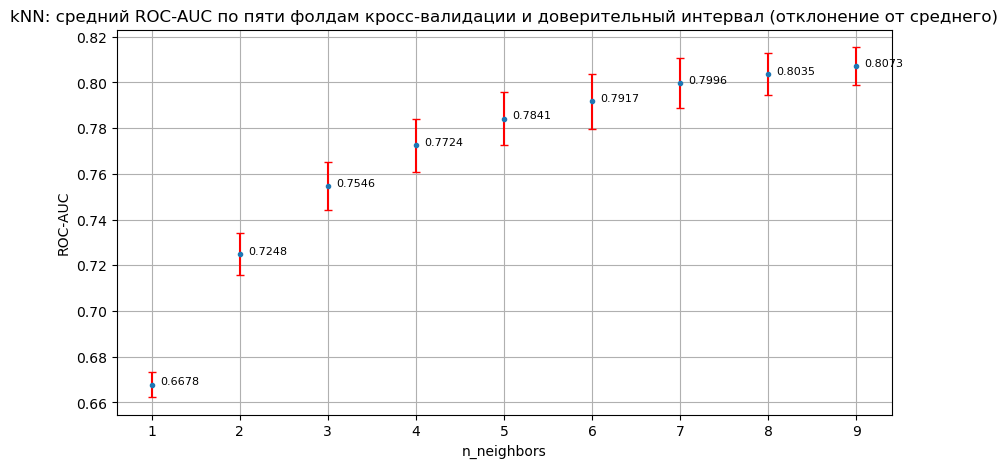

In [35]:
knn_grid = run_grid_search(knn, knn_params, X_num_scaled, y, 'kNN')
plot_cv_results(knn_grid, 'n_neighbors', 'kNN')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Лучшие гиперпараметры для SGD:  {'loss': 'log_loss'}


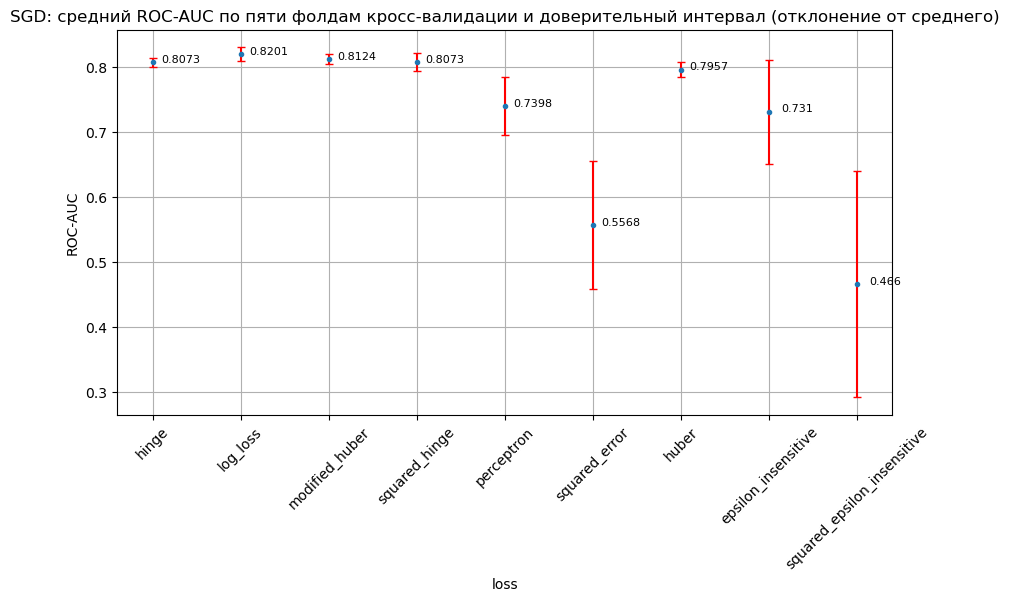

In [36]:
sgd_grid = run_grid_search(sgd, sgd_params, X_num_scaled, y, 'SGD')
plot_cv_results(sgd_grid, 'loss', 'SGD', ticks=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие гиперпараметры для Logistic Regression:  {'C': 0.1}


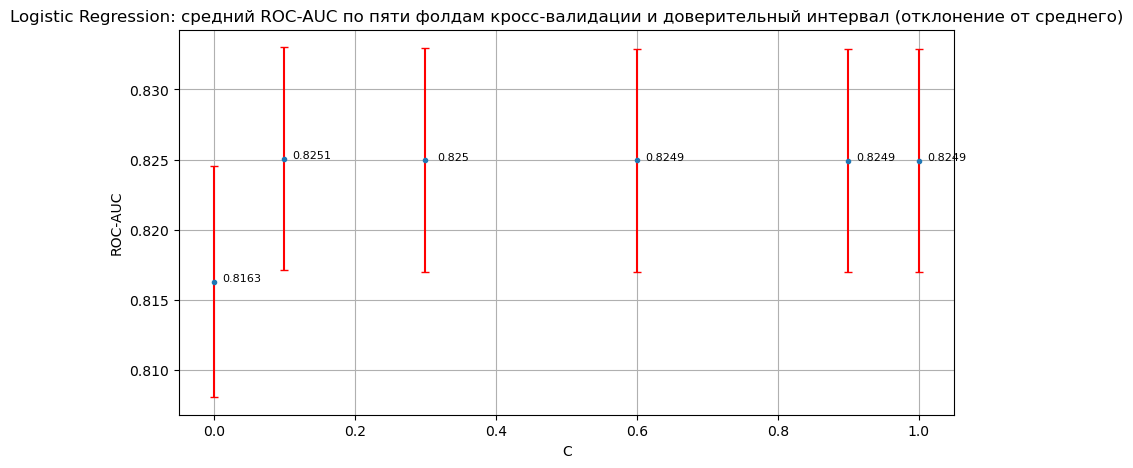

In [37]:
logreg_grid = run_grid_search(logreg, logreg_params, X_num_scaled, y, "Logistic Regression")
plot_cv_results(logreg_grid, 'C', 'Logistic Regression')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие гиперпараметры для SVC:  {'C': 0.001}


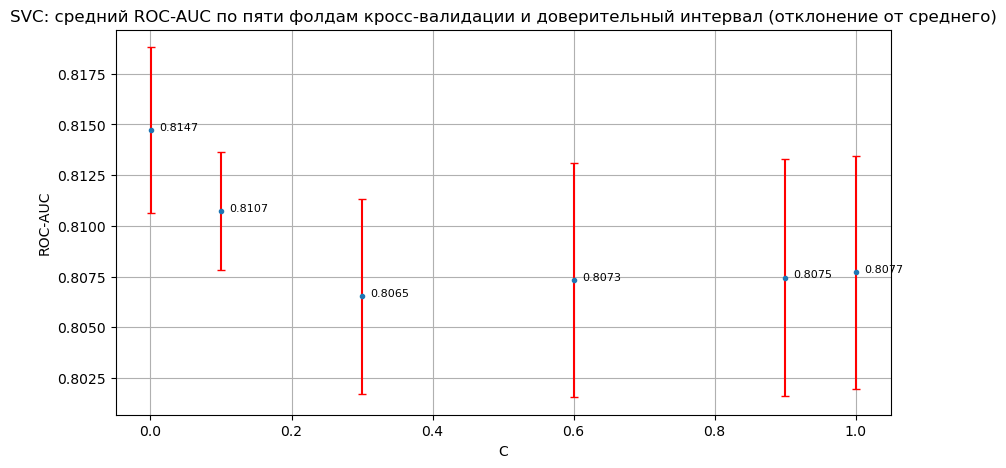

In [38]:
svc_grid = run_grid_search(svc, svc_params, X_num_scaled, y, "SVC")
plot_cv_results(svc_grid, 'C', 'SVC')

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Лучшие гиперпараметры для GNB:  {'var_smoothing': 0.001}


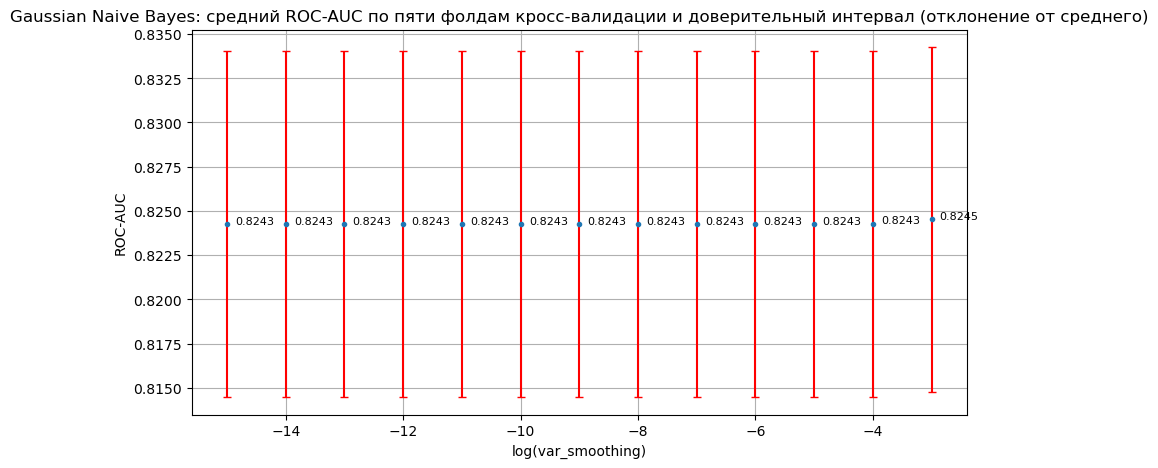

In [39]:
gnb_grid = run_grid_search(gnb, gnb_params, X_num_scaled, y, "GNB")
plot_cv_results(gnb_grid, 'var_smoothing', 'Gaussian Naive Bayes', logparam=True)

Изменилось ли качество у некоторых алгоритмов?

<font color=blue>Как и ожидалось для 4-х алгоритмов: `kNN`,`SGD`,`SVC` и `Logistic Regression` для оптимальных значений гиепрпараметров качество заметно выросло. Эти алгоритмы подтянулись по среднему значению `ROC-AUC` к `GaussianNB`. Кроме того заметно быстрее стали сходиться алгоритмы `SGD` и `Logistic Regression`.</font>

**(1,5 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае, например:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Для оставшихся трех алгоритмов самостоятельно определите, какие наборы гиперпараметров необходимо перебирать и осуществите перебор.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой.

<font color=blue>Осуществим поиск лучших гиперпараметров по выше опробованной схеме на нормализованных данных. Т.к. для каждого алгоритма теперь ищется оптимальная комбинация двух гиперпараметров, то поиск займет больше времени.</font>

In [40]:
#your code here
knn_params = {'n_neighbors': range(1, 12),
              'metric': ('cityblock', 'cosine', 'euclidean', 'haversine', 'l1', 'l2', 'manhattan')}
knn_grid = run_grid_search(knn, knn_params, X_num_scaled, y, 'kNN')

Fitting 5 folds for each of 77 candidates, totalling 385 fits
Лучшие гиперпараметры для kNN:  {'metric': 'cityblock', 'n_neighbors': 11}


In [41]:
sgd_params = {'loss': ['hinge', 'log_loss', 'modified_huber', 
                       'squared_hinge', 'perceptron', 'squared_error', 
                       'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
             'penalty': ['l2', 'l1', 'elasticnet', None]}
sgd_grid = run_grid_search(sgd, sgd_params, X_num_scaled, y, 'SGD')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие гиперпараметры для SGD:  {'loss': 'log_loss', 'penalty': 'elasticnet'}


In [42]:
logreg_params = {'C': [0.001, 0.1, 0.3, 0.6, 0.9,  1.0],
                 'penalty': ['l2', 'l1', 'elasticnet', None]}
logreg_grid = run_grid_search(logreg, logreg_params, X_num_scaled, y, 'Logistic Regression')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие гиперпараметры для Logistic Regression:  {'C': 0.1, 'penalty': 'l2'}


In [43]:
svc_params = {'C': [0.001, 0.1, 0.3, 0.6, 0.9,  1.0],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
svc_grid = run_grid_search(svc, svc_params, X_num_scaled, y, 'SVC')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие гиперпараметры для SVC:  {'C': 0.001, 'kernel': 'linear'}


In [44]:
gnb_params  = {'var_smoothing': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15],
               'priors': [[p, 1-p] for p in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)]}
gnb_grid = run_grid_search(gnb, gnb_params, X_num_scaled, y, 'GNB')

Fitting 5 folds for each of 117 candidates, totalling 585 fits
Лучшие гиперпараметры для GNB:  {'priors': [0.2, 0.8], 'var_smoothing': 0.001}


<font color=blue>Посмотрим какой из алгоритмов теперь имеет наилучшее качество. Построим таблицу с данными экспериментов.</font>

In [45]:
columns = ['best params 1', 
           'mean roc-auc (non-scaled numeric features)',
           'best params 2',
           'mean roc-auc (scaled numeric features) 1',
           'best params 3',
           'mean roc-auc (scaled numeric features) 2']
exprs = pd.DataFrame(experiments).T
exprs.columns = columns
exprs

,best params 1,mean roc-auc (non-scaled numeric features),best params 2,mean roc-auc (scaled numeric features) 1,best params 3,mean roc-auc (scaled numeric features) 2
kNN,{'n_neighbors': 6},0.6373,{'n_neighbors': 9},0.8073,"{'metric': 'cityblock', 'n_neighbors': 11}",0.8149
SGD,{'loss': 'squared_hinge'},0.6137,{'loss': 'log_loss'},0.8201,"{'loss': 'log_loss', 'penalty': 'elasticnet'}",0.8201
Logistic Regression,{'C': 0.001},0.5740,{'C': 0.1},0.8251,"{'C': 0.1, 'penalty': 'l2'}",0.8251
SVC,{'C': 0.3},0.6439,{'C': 0.001},0.8147,"{'C': 0.001, 'kernel': 'linear'}",0.8160
GNB,{'var_smoothing': 1e-10},0.8247,{'var_smoothing': 0.001},0.8245,"{'priors': [0.2, 0.8], 'var_smoothing': 0.001}",0.8245


Какой из алгоритмов имеет наилучшее качество? 

**(0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

<font color=blue>Как видно наилучшее качество (среднее значение `ROC-AUC`) равное `0.8251` показал алгоритм `Logistic Regression`.</font>

<font color=blue>Для замера времени обучения создадим словарь классификаторов с наилучшими найденными гиперпараметрами для каждого.</font>

In [46]:
classifiers = { 'Logistic Regression': LogisticRegression(C=0.1, penalty='l2', max_iter=1000, random_state=seed),
                'SGD': SGDClassifier(loss='log_loss', penalty='elasticnet', max_iter=10000, random_state=seed),
                'GNB': GaussianNB(priors=[0.2, 0.8], var_smoothing=0.001),
                'kNN': KNeighborsClassifier(metric='cityblock', n_neighbors=11),
                'SVC': SVC(C=0.001, kernel='linear', probability=True, random_state=seed)}

<font color=blue>Запустим перебор по словарю и замерим время для каждого классификатора в словаре. Расчитанное время запишем в словарь результатов экспериментов.</font>

In [47]:
for cls_name in classifiers:
    start_time = time.time()
    classifiers[cls_name].fit(X_num_scaled, y)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'{cls_name}: {elapsed_time:0.4f}')
    experiments[cls_name].append(f'{elapsed_time:0.4f}')

Logistic Regression: 0.0196
SGD: 0.0706
GNB: 0.0000
kNN: 0.0156
SVC: 41.0646


<font color=blue>Посмотрим на результаты.</font>

In [48]:
columns = ['best params 1', 
           'mean roc-auc (non-scaled numeric features)',
           'best params 2',
           'mean roc-auc (scaled numeric features) 1',
           'best params 3',
           'mean roc-auc (scaled numeric features) 2',
           'elapsed time (sec)']
exprs = pd.DataFrame(experiments).T
exprs.columns = columns
exprs

,best params 1,mean roc-auc (non-scaled numeric features),best params 2,mean roc-auc (scaled numeric features) 1,best params 3,mean roc-auc (scaled numeric features) 2,elapsed time (sec)
kNN,{'n_neighbors': 6},0.6373,{'n_neighbors': 9},0.8073,"{'metric': 'cityblock', 'n_neighbors': 11}",0.8149,0.0156
SGD,{'loss': 'squared_hinge'},0.6137,{'loss': 'log_loss'},0.8201,"{'loss': 'log_loss', 'penalty': 'elasticnet'}",0.8201,0.0706
Logistic Regression,{'C': 0.001},0.5740,{'C': 0.1},0.8251,"{'C': 0.1, 'penalty': 'l2'}",0.8251,0.0196
SVC,{'C': 0.3},0.6439,{'C': 0.001},0.8147,"{'C': 0.001, 'kernel': 'linear'}",0.8160,41.0646
GNB,{'var_smoothing': 1e-10},0.8247,{'var_smoothing': 0.001},0.8245,"{'priors': [0.2, 0.8], 'var_smoothing': 0.001}",0.8245,0.0000


<font color=blue>

Как видно все алгоритмы, кроме `SVC`, обучаются примерно за одно и то же время. Обучение `SVC` потребовало на несколько порядков больше времени.

Связано это с тем, что `SVC` работает путем поиска гиперплоскости, которая максимизирует разницу между двумя классами. Это требует решения задачи квадратичного программирования, которая имеет вычислительную сложность `O(n^3)`, где `n` - количество обучающих примеров. Это делает `SVC` более медленным для больших наборов данных.

С другой стороны, `Logistic Regression` и `SGD` имеют вычислительную сложность `O(n)`, что делает их более эффективными для больших наборов данных. `kNN` также быстрее, потому что он просто сравнивает новый пример с каждым обучающим примером, что требует меньше вычислений.

`GaussianNB` применяет теорему Байеса с предположением о независимости между признаками. Он вычисляет вероятности классов на основе средних значений и дисперсии признаков, что является относительно быстрой операцией.

</font>

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**(0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

<font color=blue>Вспомним какие признаки мы выделили в список `categorical_features` (категориальных).</font>

In [49]:
#your code here
categorical_features

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex'],
      dtype='object')

<font color=blue>Поместим `onehot` вектора категориальных признаков во фрейм `X_onehot`.</font>

In [50]:
X_onehot=pd.get_dummies(X[categorical_features], columns=categorical_features, drop_first=True, dtype='uint8')

<font color=blue>Посмотрим как выглядит фрейм `X_onehot`.</font>

In [51]:
X_onehot

,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
15343,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
15344,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
15345,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

**(0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

<font color=blue>Поместим во фрейм `X_united` объединение двух фреймов `X_num_scaled` (нормализованные числовые признаки) и `X_onehot` (`onehot` представления категориальных признаков). </font>

In [52]:
X_united = pd.concat([pd.DataFrame(X_num_scaled), X_onehot.reset_index()], axis=1)

<font color=blue>Удалим ненужную колонку `index`, образовавшуюся в результате конкатенации фреймов. </font> 

In [53]:
X_united = X_united.drop(columns=['index'])

<font color=blue>Для каждого классификатора из словаря `classifiers` запустим кросс-валидацию на данных `X_united` с помощью `cross_val_score`. Результаты (средний `roc-auc` и стандартное отклонение от среднего) поместим в словарь `experiments`. Создадим также словарь `boxplot_data` для построения диаграммы в последнем задании - в этом словаре по ключу-названию классификатора будут хранится 5 результатов кросс-валидации.</font>

In [54]:
boxplot_data = dict()
for cls_name in classifiers:
    cv_score = cross_val_score(classifiers[cls_name], np.array(X_united), y, scoring='roc_auc', cv=skf)
    boxplot_data[cls_name] = cv_score
    experiments[cls_name].append(f'{cv_score.mean():0.4f}')
    experiments[cls_name].append(f'{cv_score.std():0.4f}')
    
    print(f'{cls_name}  mean: {cv_score.mean():0.4f} std: {cv_score.std():0.4f}')

Logistic Regression  mean: 0.9034 std: 0.0042
SGD  mean: 0.9010 std: 0.0042
GNB  mean: 0.8723 std: 0.0044
kNN  mean: 0.8779 std: 0.0046
SVC  mean: 0.8890 std: 0.0054


<font color=blue>Посмотрим на результаты всех проведенных экспериментов. </font>

In [55]:
columns = ['best params 1', 
           'mean roc-auc (non-scaled numeric features)',
           'best params 2',
           'mean roc-auc (scaled numeric features) 1',
           'best params 3',
           'mean roc-auc (scaled numeric features) 2',
           'elapsed time (sec)',
           'mean roc-auc (scaled numeric features + categorical features)',
           'std roc-auc (scaled numeric features + categorical features)']
exprs = pd.DataFrame(experiments).T
exprs.columns = columns
exprs

,best params 1,mean roc-auc (non-scaled numeric features),best params 2,mean roc-auc (scaled numeric features) 1,best params 3,mean roc-auc (scaled numeric features) 2,elapsed time (sec),mean roc-auc (scaled numeric features + categorical features),std roc-auc (scaled numeric features + categorical features)
kNN,{'n_neighbors': 6},0.6373,{'n_neighbors': 9},0.8073,"{'metric': 'cityblock', 'n_neighbors': 11}",0.8149,0.0156,0.8779,0.0046
SGD,{'loss': 'squared_hinge'},0.6137,{'loss': 'log_loss'},0.8201,"{'loss': 'log_loss', 'penalty': 'elasticnet'}",0.8201,0.0706,0.9010,0.0042
Logistic Regression,{'C': 0.001},0.5740,{'C': 0.1},0.8251,"{'C': 0.1, 'penalty': 'l2'}",0.8251,0.0196,0.9034,0.0042
SVC,{'C': 0.3},0.6439,{'C': 0.001},0.8147,"{'C': 0.001, 'kernel': 'linear'}",0.8160,41.0646,0.8890,0.0054
GNB,{'var_smoothing': 1e-10},0.8247,{'var_smoothing': 0.001},0.8245,"{'priors': [0.2, 0.8], 'var_smoothing': 0.001}",0.8245,0.0000,0.8723,0.0044


<font color=blue>Как видно добавление категориальных признаков дало заметный прирост качества `ROC-AUC` для всех алгоритмов. Для `SGD` и `Logistic Regression` оно достигло `0.9`.</font> 

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

<font color=blue>Нет. Попрежнему лучшее качество у алгоритма `Logistic Regression`.</font>

## Смешивание моделей

Во всех предыдущих пунктах мы получили много хороших моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и логистическая регрессия). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее качество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**(1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

<font color=blue>

Создадим класс `Blender`.
    
Метод `__init__` создает у объекта этого класса два классификатора, которые показали лучшее качество в последнем эксперимента: `clf1`  и `clf2`.
    
Метод `fit(X, y)` обучает оба классификатора на передаваемых в него данных `X` и `y`.

Для вычисления качества `roc-auc` используется библиотечная функция `roc_auc_score`, в которую предсказание передается как вектор вероятностей положительного класса. Поэтому в `Blender` имплементирован метод `predict_proba(X, alpha)`, который вычисляет вектор вероятностей положительного класса для входных данных `X` как линейную комбинацию (с коэффициентами `alpha` и `1-alpha`) векторов вероятностей, предсказанных обученными классификаторами `clf1`  и `clf2`. 
    
Также имеется метод `predict(X)`, который возвращает вектор предсказанных классов (`0` или `1`) по вектору `predict_proba` c пороговым значением `0.5`. В дальнейших расчетах этот метод не используется - для расчета качества `roc-auc` он не нужен.

</font>

In [56]:
#your code here
class Blender:
    def __init__(self, clf1, clf2):
        self.clf1 = clf1
        self.clf2 = clf2
    
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.clf1.fit(X, y)
        self.clf2.fit(X, y)
        return self
    
    def predict_proba(self, X, alpha=0.5):
        X = np.asarray(X)
        res = self.clf1.predict_proba(X)[:, 1] * alpha + self.clf2.predict_proba(X)[:, 1] * (1 - alpha)
        return res
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

<font color=blue>Функция `blender_cross_val(blender, X, y, cv)` осуществляет поиск лучшего гиперпараметра `alpha` и возвращает фрейм с результами всех экспериментов и название колонки с лучшим средним значением `ROC-AUC`. Используется кросс-валидация  смешанной модели `Blender` на 5-ти фолдах выборки `X`, размеченной вектором `y`.</font>

In [57]:
def blender_cross_val(blender, X, y, cv, verbose=True):
    X = np.asarray(X)
    y = np.asarray(y)
    roc_auc_dict = dict()
    alphas = np.linspace(0, 1, 11)

    for fold, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_true = y[test_index]
        roc_auc_dict[f'fold{fold}'] = list()
        blender.fit(X_train, y_train)
        for alpha in alphas:
            y_pred = blender.predict_proba(X_test, alpha)
            roc_auc_dict[f'fold{fold}'].append(roc_auc_score(y_true, y_pred))
            
    df_res = pd.DataFrame(roc_auc_dict).T
    df_res.columns = [f'alpha={a:.2f}' for a in alphas]
    best_column = df_res.columns[df_res.mean().argmax()]
    if verbose:
        print(f'Лучшее среднее значение ROC-AUC {df_res.mean().max():.4f} для {best_column}')
    
    
    return df_res, best_column

<font color=blue>Посмотрим на результаты кросс-валидации всех возможных смешанных моделей (10 разных комбинаций). Также поместим необходимые данные в словарь `boxplot_data`.</font>

In [58]:
pairs = list()
for clf1_key in classifiers.keys():
    for clf2_key in classifiers.keys():
        if clf1_key == clf2_key or {clf1_key, clf2_key} in pairs:
            continue
        pairs.append({clf1_key, clf2_key})
        cls_name = f'{clf1_key} + {clf2_key}'
        print(cls_name)
        res, bc = blender_cross_val(Blender(classifiers[clf1_key], classifiers[clf2_key]), X_united, y, skf)
        boxplot_data[cls_name] = np.array(res[bc])
        print()

Logistic Regression + SGD
Лучшее среднее значение ROC-AUC 0.9034 для alpha=0.90

Logistic Regression + GNB
Лучшее среднее значение ROC-AUC 0.9034 для alpha=1.00

Logistic Regression + kNN
Лучшее среднее значение ROC-AUC 0.9046 для alpha=0.80

Logistic Regression + SVC
Лучшее среднее значение ROC-AUC 0.9034 для alpha=1.00

SGD + GNB
Лучшее среднее значение ROC-AUC 0.9010 для alpha=1.00

SGD + kNN
Лучшее среднее значение ROC-AUC 0.9033 для alpha=0.80

SGD + SVC
Лучшее среднее значение ROC-AUC 0.9019 для alpha=0.80

GNB + kNN
Лучшее среднее значение ROC-AUC 0.8904 для alpha=0.20

GNB + SVC
Лучшее среднее значение ROC-AUC 0.8935 для alpha=0.20

kNN + SVC
Лучшее среднее значение ROC-AUC 0.8945 для alpha=0.40



<font color=blue>Видно, что в ряде случаев оптимальным `alpha` оказалось значение 1, т.е. второй классификатор в комбинации оказался бесполезным. Комбинация двух лучших классификаторов `Logistic Regression` и `SGD` дало еле заметное улучшение `ROC-AUC` - это улучшение фиксируется после 4-го знака после запятой.  Только в одном случае (комбинация `Logistic Regression` и `kNN` при `alpha=0.8`) удалось получить улучшение среднего `ROC-AUC` в 3-м знаке после запятой. Это значение `ROC-AUC` самое большое из всех полученных в экспериментах.</font> 

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**(1 балл)** Для каждого типа классификатора (kNN, SGD classifier и т.д.), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

<font color=blue>Взглянем на наш словарь `boxplot_data` с лучшими результами валидации для разных классификаторов, в т.ч. смешанных.</font>

In [59]:
pd.DataFrame(boxplot_data)

,Logistic Regression,SGD,GNB,kNN,SVC,Logistic Regression + SGD,Logistic Regression + GNB,Logistic Regression + kNN,Logistic Regression + SVC,SGD + GNB,SGD + kNN,SGD + SVC,GNB + kNN,GNB + SVC,kNN + SVC
0,0.901204,0.899456,0.874151,0.880408,0.888157,0.901243,0.901204,0.903409,0.901204,0.899456,0.902091,0.899407,0.894638,0.893329,0.894941
1,0.906869,0.903705,0.878862,0.880968,0.893489,0.906820,0.906869,0.907025,0.906869,0.903705,0.905430,0.905311,0.892625,0.897808,0.897562
2,0.896242,0.893382,0.865773,0.868867,0.881590,0.896382,0.896242,0.897700,0.896242,0.893382,0.896588,0.895516,0.881658,0.887550,0.887222
3,0.905675,0.904729,0.872690,0.880999,0.885148,0.905673,0.905675,0.907153,0.905675,0.904729,0.906564,0.903409,0.892940,0.891152,0.893391
4,0.907138,0.903878,0.869925,0.878372,0.896427,0.907047,0.907138,0.907717,0.907138,0.903878,0.905602,0.905640,0.890307,0.897850,0.899449


<font color=blue>Наc не интересуют смешанные классификаторы с лучшим `alpha=1` т.к. это по сути дублирование одиночных классификаторов. Поэтому сгенерируем немного урезанный словарь.</font>

In [60]:
actual_boxplot_data = boxplot_data.copy()
del actual_boxplot_data['Logistic Regression + GNB']
del actual_boxplot_data['Logistic Regression + SVC']
del actual_boxplot_data['SGD + GNB']

In [61]:
pd.DataFrame(actual_boxplot_data)

,Logistic Regression,SGD,GNB,kNN,SVC,Logistic Regression + SGD,Logistic Regression + kNN,SGD + kNN,SGD + SVC,GNB + kNN,GNB + SVC,kNN + SVC
0,0.901204,0.899456,0.874151,0.880408,0.888157,0.901243,0.903409,0.902091,0.899407,0.894638,0.893329,0.894941
1,0.906869,0.903705,0.878862,0.880968,0.893489,0.906820,0.907025,0.905430,0.905311,0.892625,0.897808,0.897562
2,0.896242,0.893382,0.865773,0.868867,0.881590,0.896382,0.897700,0.896588,0.895516,0.881658,0.887550,0.887222
3,0.905675,0.904729,0.872690,0.880999,0.885148,0.905673,0.907153,0.906564,0.903409,0.892940,0.891152,0.893391
4,0.907138,0.903878,0.869925,0.878372,0.896427,0.907047,0.907717,0.905602,0.905640,0.890307,0.897850,0.899449


<font color=blue>Теперь по этим данным для каждого классификатора построим ящик с усами на одной диаграмме.</font>

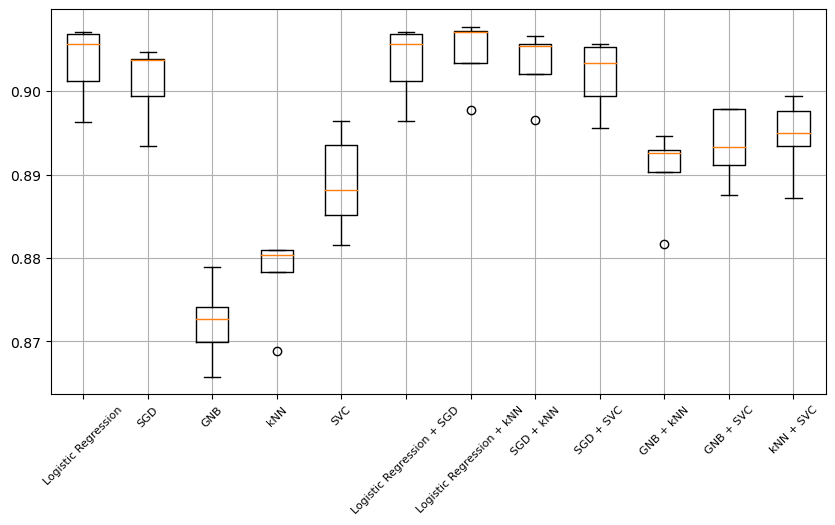

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(actual_boxplot_data.values())
ax.grid()
ax.set_xticklabels(actual_boxplot_data.keys(), rotation=45, fontsize=8)

plt.show()

<font color=blue>Видно, что в среднем смешанные модели имеют более высокое качество `ROC-AUC`, чем одинарные.</font>

<font color=blue>

Почти во всех случаях стандартизация числовых признаков улучшила качество модели, кроме может быть `GaussianNB` (у этой модели качество осталось на прежнем уровне для оптимального гиперпараметра). Также стоит отметить, что все модели после добавления категориальных признаков заметно повысили качество `ROC-AUC`.

Эксперименты показали, что в зависимости от модели и гиперпараметра перебор по сетке может приводить и к заметному улучшению качества, и к слабо заметному. Например, `ROC-AUC` модели `kNN` сильно зависит от гиперпараметра `n_neighbors`, но перебор по гиперпараметру `metric` дал совсем не большое улучшение. Аналогично для модели `SGD` можно отметить заметное влияние на модель гиперпараметра `loss`, но слабое влияние гиперпараметра `penalty`.  Можно также отметить не очень большое влияние гиперпараметра `C` на модели `SVC` и `Logistic Regression`. После нормализации данных совсем исчезло влияние гиперпараметра `var_smoothing` на модель `GaussianNB`.

</font>